# Project 2: In-Depth Exploratory Data Analysis (EDA)
## Netflix Content Analysis 🎬

**Project Objective:** To perform an in-depth exploratory data analysis of the Netflix dataset. We will explore trends in content production, identify popular genres, analyze content ratings, and understand the distribution of movies and TV shows on the platform. This project builds on foundational EDA by introducing time-series analysis and more complex data cleaning and transformation techniques.

### Core Concepts We'll Cover:
1.  **Data Cleaning & Transformation:** Handling missing values and converting data types (especially dates).
2.  **Time-Series Analysis:** Analyzing how content has been added to Netflix over the years.
3.  **Text Data Manipulation:** Parsing and analyzing columns with multiple values, like `listed_in` (genres) and `cast`.
4.  **Geographical & Rating Analysis:** Understanding where content comes from and its maturity level.
5.  **Feature Engineering:** Creating new, insightful features like 'content age'.
6.  **Advanced Visualization:** Creating insightful plots to understand distributions and relationships in the data.

### Step 1: Setup - Importing Libraries

As always, we begin by importing our essential data science toolset, including a new library for word clouds.

In [100]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Set a consistent style for our plots
sns.set_style('darkgrid')

### Step 2: Data Loading and Initial Inspection

In [101]:
netflix_df = pd.read_csv('https://raw.githubusercontent.com/kush-agra-soni/2_Netflix-s_Content_Strategy/refs/heads/main/netflix_titles.csv')
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [102]:
# Get a concise summary of the dataframe
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


**Interpretation of `.info()`:**
- We have 7787 entries (titles).
- **Key Problem:** The `date_added` column is of type `object` (a string), not a `datetime` object. We cannot perform time-based analysis until this is corrected.
- **Missing Values:** `director`, `cast`, `country`, `date_added`, and `rating` all have missing values. `director` has the most significant number of nulls.

### Step 3: Data Cleaning and Transformation

#### **Theoretical Concept: Data Type Conversion & Handling Nulls**
Data often comes in non-ideal formats. Storing dates as strings, for example, prevents us from extracting components like the year or month, or from plotting data over time. Converting columns to their proper data types (`pd.to_datetime`, `.astype()`) is a fundamental preprocessing step.

For null values, we have several strategies:
1.  **Drop:** If only a very small percentage of rows have missing data, dropping them might be acceptable (`.dropna()`).
2.  **Fill/Impute:** Replace missing values with a placeholder (like "Unknown") or a statistical measure (like the mode for categorical data). This is useful when you don't want to lose the other information in those rows.

In [103]:
# 1. Handle missing values in 'director' and 'cast' with 'Unknown'.
netflix_df['director'] = netflix_df['director'].fillna('Unknown')
netflix_df['cast'] = netflix_df['cast'].fillna('Unknown')

In [104]:
# 2. Handle missing 'country' (Mode)
mode_country = netflix_df['country'].mode()[0]
netflix_df['country'] = netflix_df['country'].fillna(mode_country)

In [105]:
# 3. Drop the few rows with missing 'date_added' and 'rating' (Drop)
netflix_df.dropna(subset=['date_added', 'rating'], inplace=True)

In [106]:
# 4. Convert 'date_added' to datetime objects (format='mixed')
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], format='mixed', dayfirst=False)

* **format='mixed':** This argument tells pandas to infer the date format automatically. This is helpful when the date strings in the column have different formats.

* **dayfirst=False:** This argument specifies that when the date format is ambiguous (e.g., 01/02/2023), it should be interpreted as month first (January 2nd) rather than day first (February 1st).

In [107]:
# 5. Create new features for year and month added
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['month_added'] = netflix_df['date_added'].dt.month

In [108]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7770 entries, 0 to 7786
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       7770 non-null   object        
 1   type          7770 non-null   object        
 2   title         7770 non-null   object        
 3   director      7770 non-null   object        
 4   cast          7770 non-null   object        
 5   country       7770 non-null   object        
 6   date_added    7770 non-null   datetime64[ns]
 7   release_year  7770 non-null   int64         
 8   rating        7770 non-null   object        
 9   duration      7770 non-null   object        
 10  listed_in     7770 non-null   object        
 11  description   7770 non-null   object        
 12  year_added    7770 non-null   int32         
 13  month_added   7770 non-null   int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(10)
memory usage: 849.8+ KB


### Step 4: Exploratory Data Analysis & Visualization

#### 4.1 What is the distribution of content type?

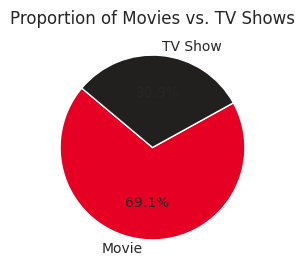

In [109]:
plt.figure(figsize=(5, 3))
type_counts = netflix_df['type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=['#e60023', '#221f1f'])
plt.title('Proportion of Movies vs. TV Shows')
plt.ylabel('')
plt.show()

**Insight:** The Netflix library is dominated by Movies, which make up roughly 70% of the content in this dataset.

#### 4.2 How has content been added over time?

<Figure size 800x300 with 0 Axes>

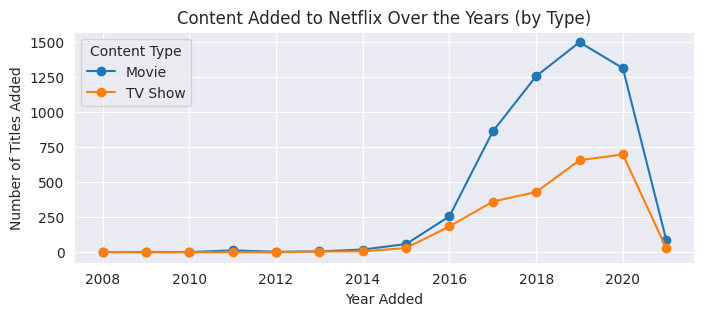

In [110]:
# Group data by year and content type
content_over_time = netflix_df.groupby(['year_added', 'type']).size().unstack().fillna(0)

plt.figure(figsize=(8, 3))
content_over_time.plot(kind='line', marker='o', figsize=(8, 3))
plt.title('Content Added to Netflix Over the Years (by Type)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles Added')
plt.legend(title='Content Type')
plt.grid(True)
plt.show()

**Insight:** By separating movies and TV shows, we can see that while both grew significantly, the addition of movies accelerated much more dramatically, peaking in 2019. The growth in TV shows has been more steady. There appears to be a slight slowdown in content additions in 2020 and 2021, which could be due to the COVID-19 pandemic affecting productions or the dataset being incomplete for the latest year.

#### 4.3 What are the most popular genres?

#### **Theoretical Concept: Handling Multi-Value Text Columns**
The `listed_in` column contains strings with multiple genres separated by commas (e.g., "Dramas, International Movies"). To analyze each genre individually, we need to transform the data. A common technique is to:
1.  **Split** the string in each row into a list of genres.
2.  **Explode** the DataFrame so that each genre in the list gets its own row, duplicating the other information for that title.
This allows us to perform a `value_counts()` on the genres.

In [111]:
# Split the 'listed_in' column and explode it
genres = netflix_df.assign(genre=netflix_df['listed_in'].str.split(', ')).explode('genre')

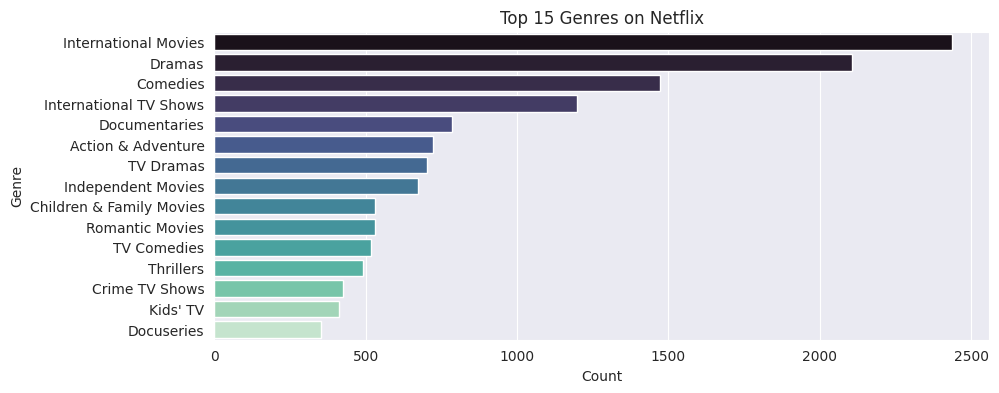

In [112]:
# Get the top 15 genres and their counts
top_genres_counts = genres['genre'].value_counts().reset_index()
top_genres_counts.columns = ['genre', 'count'] # Rename columns for clarity

# Select only the top 15 for plotting
top_genres_counts_plot = top_genres_counts.head(15)

plt.figure(figsize=(10, 4))
sns.barplot(y='genre', x='count', data=top_genres_counts_plot, palette='mako', hue='genre', legend=False)
plt.title('Top 15 Genres on Netflix')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

**Insight:** "International Movies" is the most common genre tag, highlighting Netflix's global content strategy. This is followed by Dramas, Comedies, and Action & Adventure.

#### 4.4 What is the distribution of content duration?

In [113]:
# Separate movies and TV shows
movies_df = netflix_df[netflix_df['type'] == 'Movie'].copy()
tv_shows_df = netflix_df[netflix_df['type'] == 'TV Show'].copy()

In [114]:
# Clean and convert duration for movies
movies_df['duration_min'] = movies_df['duration'].str.replace(' min', '').astype(int)

# Clean and convert duration for TV shows
tv_shows_df['seasons'] = tv_shows_df['duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(int)

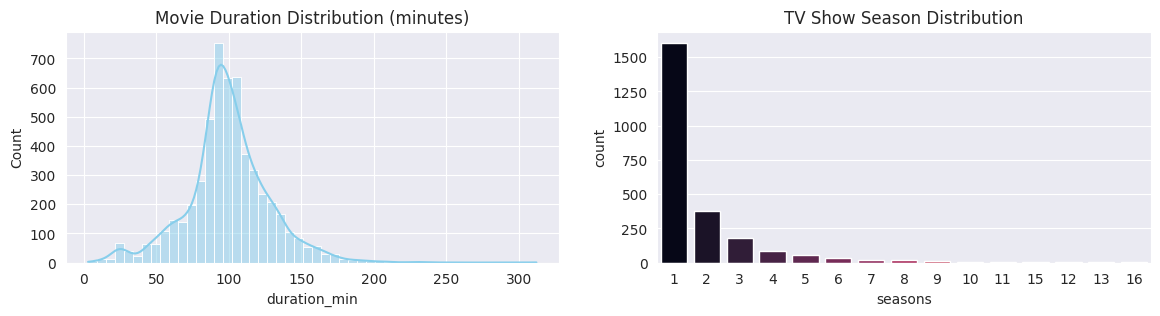

In [115]:
# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 3))

# Movie Duration Distribution
sns.histplot(ax=axes[0], data=movies_df, x='duration_min', bins=50, kde=True, color='skyblue').set_title('Movie Duration Distribution (minutes)')

# TV Show Season Distribution
sns.countplot(ax=axes[1], x='seasons', data=tv_shows_df, palette='rocket', order=tv_shows_df['seasons'].value_counts().index, hue='seasons', legend=False).set_title('TV Show Season Distribution')

plt.show()

**Insight:**
- The majority of movies on Netflix are between 80 and 120 minutes long, which is standard for feature films.
- The vast majority of TV shows on Netflix are short-lived, with most having only 1 season. This could reflect a strategy of producing many pilots and only renewing the most successful ones, or a focus on limited series.

#### 4.5 Where does the content come from? (Geographical Analysis)

In [116]:
# Handle the multi-country listings similar to genres
countries = netflix_df.assign(country=netflix_df['country'].str.split(', ')).explode('country')

In [117]:
# Get the top 15 countries and their counts
top_countries_counts = countries['country'].value_counts().reset_index()
top_countries_counts.columns = ['country', 'count'] # Rename columns for clarity

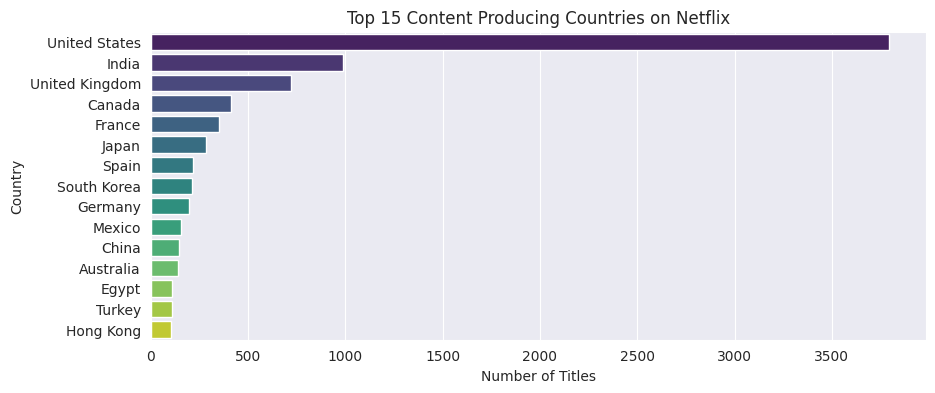

In [118]:
# Select only the top 15 for plotting
top_countries_counts_plot = top_countries_counts.head(15)

plt.figure(figsize=(10, 4))
sns.barplot(y='country', x='count', data=top_countries_counts_plot, palette='viridis', hue='country', legend=False)
plt.title('Top 15 Content Producing Countries on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.show()

**Insight:** The United States is by far the largest producer of content available on Netflix. However, India is a very strong second, which explains why so many of the top actors were from India. The UK, Japan, and South Korea also represent major content markets for the platform, emphasizing its global nature.

#### 4.6 What are the maturity ratings of the content?

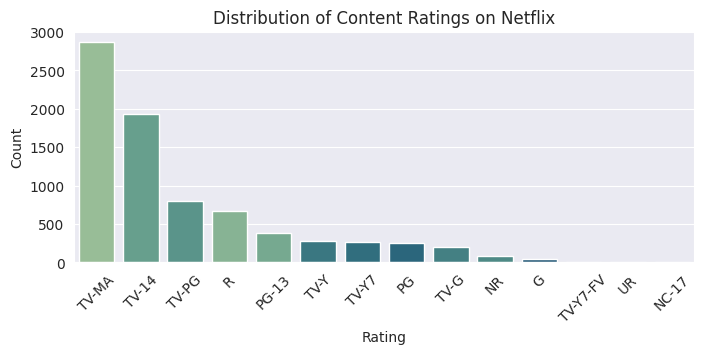

In [86]:
plt.figure(figsize=(8, 3))
sns.countplot(x='rating', data=netflix_df, order=netflix_df['rating'].value_counts().index, palette='crest', hue='rating', legend=False)
plt.title('Distribution of Content Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Insight:** A large portion of Netflix's content is aimed at mature audiences, with `TV-MA` (Mature Audience) and `TV-14` (Parents Strongly Cautioned) being the two most common ratings. This suggests a focus on adult viewers over content for children (`TV-G`, `TV-Y`).

### Step 5: Feature Engineering - Content Freshness
Let's create a new feature to analyze how old content is when it gets added to Netflix. This can tell us about their acquisition strategy (buying old classics vs. releasing new originals).

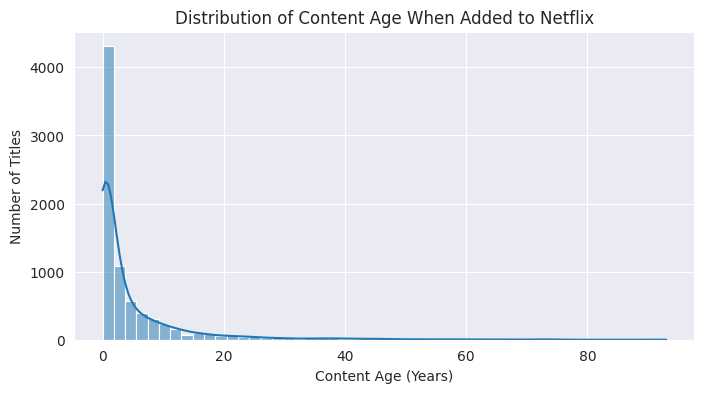

In [87]:
# Create the 'age_on_netflix' feature
netflix_df['age_on_netflix'] = netflix_df['year_added'] - netflix_df['release_year']

# Filter out any potential errors where added_year is before release_year
content_age = netflix_df[netflix_df['age_on_netflix'] >= 0]

plt.figure(figsize=(8, 4))
sns.histplot(data=content_age, x='age_on_netflix', bins=50, kde=True)
plt.title('Distribution of Content Age When Added to Netflix')
plt.xlabel('Content Age (Years)')
plt.ylabel('Number of Titles')
plt.show()

**Insight:** The large spike at `0` indicates that a significant amount of content is added in the same year it's released, which is characteristic of "Netflix Originals." However, there is a very long tail, showing that Netflix also heavily invests in acquiring licensed content that can be decades old, building a deep library of classic films and shows.

### Step 6: Deeper Multivariate Analysis

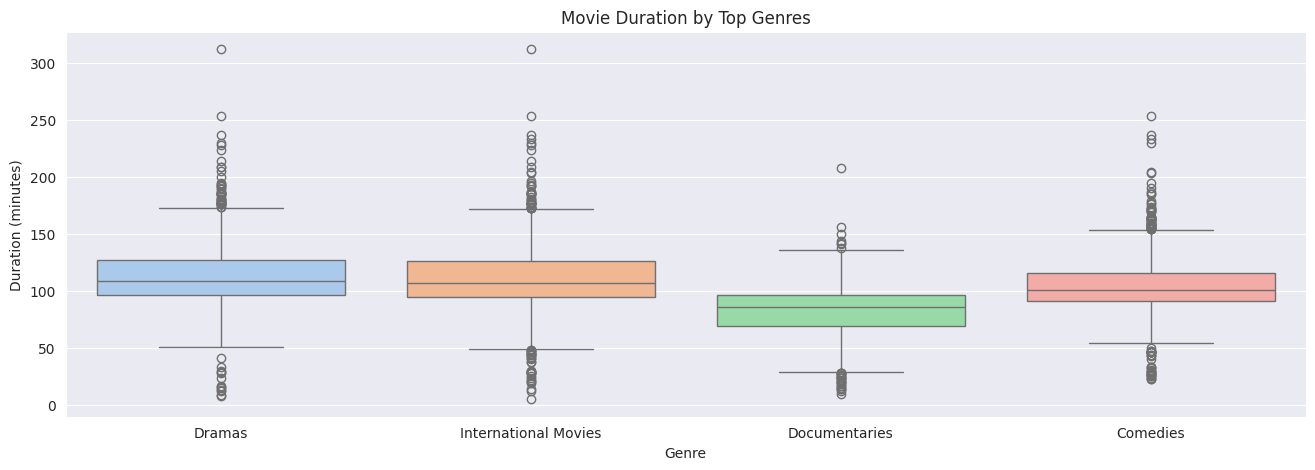

In [88]:
# Analyze movie duration across different top genres
top_genres = genres['genre'].value_counts().index[:5]
genres_movies = genres[(genres['type'] == 'Movie') & (genres['genre'].isin(top_genres))].copy()
genres_movies['duration_min'] = genres_movies['duration'].str.replace(' min', '').astype(int)

plt.figure(figsize=(16, 5))
sns.boxplot(data=genres_movies, x='genre', y='duration_min', palette='pastel', hue='genre', legend=False)
plt.title('Movie Duration by Top Genres')
plt.xlabel('Genre')
plt.ylabel('Duration (minutes)')
plt.show()

**Insight:** While the median duration for most top genres is similar (around 90-100 minutes), we can see some interesting variations. For example, Dramas tend to have a wider range of durations, with many longer films. International Movies also show a broad distribution, reflecting diverse filmmaking styles from around the world.

### Step 7: Word Cloud from Content Descriptions
As a final visual analysis, let's generate a word cloud from the `description` column to see what themes and words are most common in Netflix content.

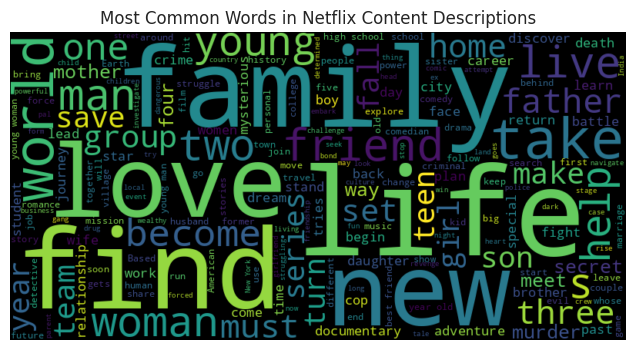

In [89]:
# Combine all descriptions into a single string
text = ' '.join(netflix_df['description'])

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the generated image
plt.figure(figsize=(16, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Content Descriptions', fontsize=12)
plt.show()

**Insight:** The word cloud highlights common themes and subjects. Words like "life," "family," "love," "young," "friends," and "world" are prominent, suggesting that much of the content revolves around human relationships and personal journeys. Action-oriented words like "find," "secret," and "new" also appear frequently.

### Step 8: Final Conclusion and Summary of Insights

This in-depth EDA of the Netflix dataset has revealed several key characteristics and strategies of the platform's content library.

**Key Findings:**
1.  **Content Strategy:** Netflix's library is movie-heavy (~70%), and the platform aggressively added content between 2016-2019. Their strategy involves a mix of brand new originals (added the same year they are released) and a deep library of licensed older content.
2.  **Global Dominance:** While the US is the top content producer, the platform is heavily international, with India being a massive contributor. This is reflected in the top genres ("International Movies") and most frequent actors.
3.  **Target Audience:** The content library is skewed towards mature audiences, with `TV-MA` and `TV-14` being the most common ratings.
4.  **Content Format & Genre:** Dramas and Comedies are universally popular genres. Most movies stick to a standard 90-120 minute runtime, while the vast majority of TV shows only last for a single season, suggesting a high-risk, high-reward approach to series production.
5.  **Common Themes:** Descriptions of content frequently revolve around universal themes of life, family, love, and discovery.

**Limitations:** This dataset is a snapshot in time and lacks viewership data. Therefore, our analysis is of the *supply* of content, not its *demand* or popularity. Nonetheless, this EDA provides a strong, multi-faceted understanding of the composition and evolution of the Netflix library.

# Submission Q's

##Q1 How has the distribution of content ratings changed over time?

In [90]:
main_ratings = ['TV-MA', 'TV-14', 'PG-13', 'R']

ratings_summary = (
    netflix_df.groupby(['year_added', 'rating']).size().unstack(fill_value=0)
      .assign(Others=lambda x: x.drop(columns=main_ratings, errors='ignore').sum(axis=1))
      [main_ratings + ['Others']]
      .astype(int)
)

print(ratings_summary.head(10))

rating      TV-MA  TV-14  PG-13   R  Others
year_added                                 
2008            2      0      0   0       0
2009            2      0      0   0       0
2010            0      0      0   0       1
2011            3      5      0   0       5
2012            0      0      0   1       2
2013            3      2      0   0       6
2014           12      2      0   0      11
2015           29     15      2   3      39
2016          163    103      6  14     154
2017          455    339     26  66     336


<Axes: xlabel='year_added'>

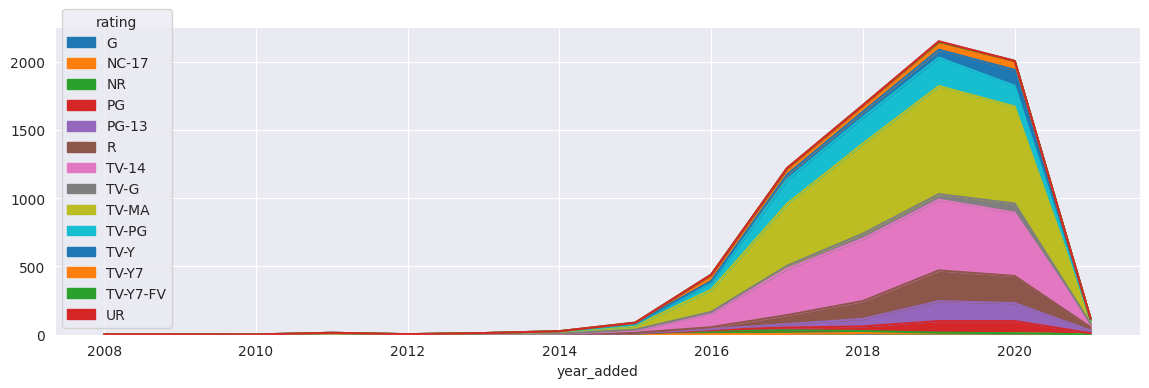

In [91]:
ratings_trend = netflix_df.groupby(['year_added','rating']).size().reset_index(name='count')
ratings_pivot = ratings_trend.pivot(index='year_added', columns='rating', values='count').fillna(0)
ratings_pivot.plot.area(figsize=(14,4))

#### Insights: Distribution of Content Ratings Over Time

- **Sharp Growth (2016–2019):** Netflix aggressively expanded its library, with a surge in content additions across all ratings.  
- **Dominance of Mature Content:** TV-MA and TV-14 grew the fastest, making up the majority of content after 2017.  
- **Family/Kid Content Steady:** Ratings like TV-Y, TV-G, and TV-Y7 remained relatively flat, showing limited growth.  
- **Strategic Shift:** The trend reflects Netflix’s focus on teen and adult audiences, prioritizing thrillers, dramas, and originals over general family content.  
- **Post-2020 Decline:** Noticeable dip after 2020, likely due to market saturation and pandemic-related production slowdowns.


##2. Is there a relationship between content age and its type (Movie vs. TV Show)?

In [92]:
# Percentage of content older than 3 years
threshold = 3

pct_by_type = (
    netflix_df.assign(old=lambda x: x['age_on_netflix'] > threshold)
      .groupby(['type','old'])
      .size()
      .groupby(level=0)
      .apply(lambda x: round(100 * x / x.sum(), 1))
      .unstack(fill_value=0)
)

pct_by_type.columns = ['≤3 years', '>3 years']
print(pct_by_type)

                 ≤3 years  >3 years
type    type                       
Movie   Movie        64.4      35.6
TV Show TV Show      80.9      19.1


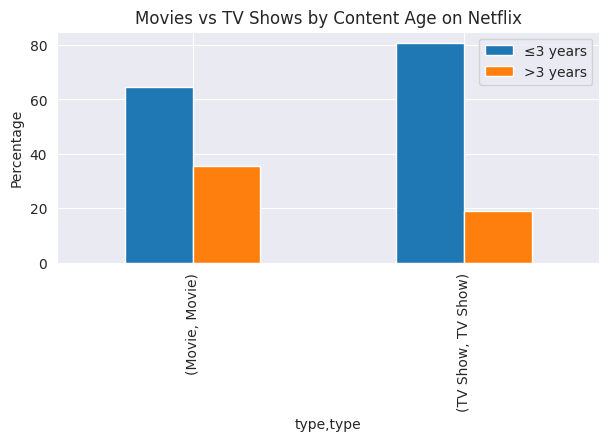

In [93]:
pct_by_type.plot(kind='bar', stacked=False, figsize=(7,3))
plt.ylabel("Percentage")
plt.title("Movies vs TV Shows by Content Age on Netflix")
plt.show()

####Based on the chart, here are four key takeaways:

-TV shows are mostly recent: Around 80% of TV shows on Netflix are three years old or newer, showing a focus on current content.

-Movies have more older content: Over 35% of movies are older than three years, indicating a more varied film library that includes classic titles.

-Different strategies for each type: Netflix seems to prioritize new TV series for engagement, while its movie selection offers a mix of both new and older films.

-Age differs significantly by type: The content age distribution is not uniform; TV shows are far more recent on average than movies.

##3. Can we identify any trends in content production based on the release year vs. the year added to Netflix?


In [94]:
netflix_df['lag_years'] = netflix_df['year_added'] - netflix_df['release_year']

lag_summary = netflix_df['lag_years'].describe(percentiles=[0.25,0.5,0.75]).round(1)
print(lag_summary)

count    7770.0
mean        4.6
std         8.7
min        -3.0
25%         0.0
50%         1.0
75%         5.0
max        93.0
Name: lag_years, dtype: float64


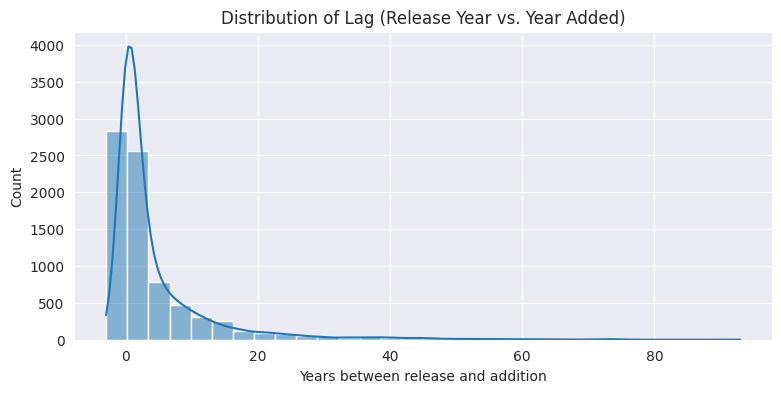

In [95]:
plt.figure(figsize=(9,4))
sns.histplot(netflix_df['lag_years'], bins=30, kde=True)
plt.title("Distribution of Lag (Release Year vs. Year Added)")
plt.xlabel("Years between release and addition")
plt.show()

Based on the provided histogram, here are four key insights about the time difference between a title's release year and when it was added to Netflix:

1.  **Netflix focuses on recent content:** The vast majority of titles are added to Netflix either in the same year they were released or within a few years of their release. This is shown by the towering bar at the "0" mark and the steep drop-off immediately after.

2.  **A small percentage of the library is older:** While most content is recent, there's a long tail stretching out to 80 or 90 years. This indicates a small but significant portion of the library consists of much older movies or TV shows, likely classics or historical titles.

3.  **The lag is highly skewed:** The distribution is highly right-skewed, meaning the average lag time is pulled up by a few very old titles, while the majority of titles were added quickly after their release.

4.  **Licensing strategies vary:** The presence of a large number of titles with a zero or low lag time suggests Netflix produces its own original content or has licensing deals for new releases. The "long tail" shows they also acquire rights to older titles, which can be part of a strategy to provide a comprehensive and diverse library.

##4. What are the most common word pairs or phrases in content descriptions?

In [96]:
# Finding the word pairs with length > 4

text = " ".join(netflix_df['description'].dropna()).lower()
words = re.findall(r'\b\w+\b', text)
top_bigrams = Counter(f'{words[i]} {words[i+1]}' for i in range(len(words)-1) if len(words[i]) > 4 and len(words[i+1]) > 4).most_common(10)

for phrase, count in top_bigrams:
    print(phrase, ":", count)

young woman : 98
their lives : 86
years after : 58
finds himself : 46
after being : 45
documentary follows : 36
finds herself : 36
documentary series : 35
serial killer : 32
social media : 27


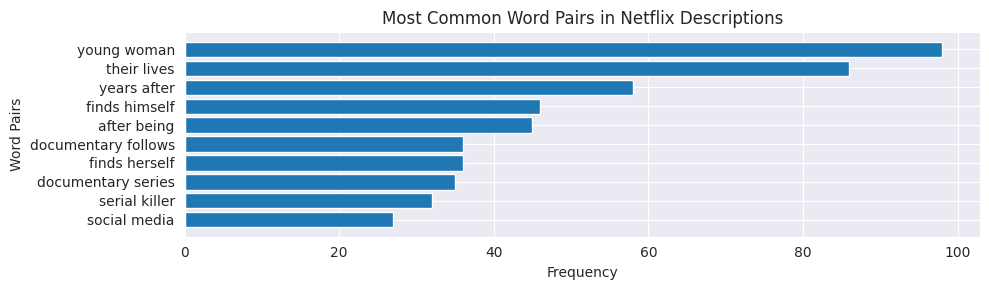

In [97]:
# Convert the list of tuples into a pandas DataFrame for plotting
ngram_freq = pd.DataFrame(top_bigrams, columns=['ngram', 'count'])

plt.figure(figsize=(10, 3))
plt.barh(ngram_freq['ngram'], ngram_freq['count'])
plt.gca().invert_yaxis()
plt.title("Most Common Word Pairs in Netflix Descriptions")
plt.xlabel("Frequency")
plt.ylabel("Word Pairs")
plt.tight_layout()

---

* **Identifies Dominant Genres:** The most frequent word pairs, or bigrams, directly show the **most common genres and themes** on the platform, such as 'family drama' or 'high school'.
* **Aids Recommendations:** These pairs represent the core language used in descriptions, helping Netflix's algorithm **match users to content** based on their preferences more effectively.
* **Informs Content Strategy:** The data reveals which genres are thriving and where there might be gaps, allowing Netflix to **make data-driven decisions** on what new content to produce or acquire.

## 5. Who are the top directors on Netflix?

In [98]:
# Handle directors: split by comma, strip spaces, explode into rows
directors_cleaned = (netflix_df.assign(director=netflix_df['director'].replace('', 'Unknown').fillna('Unknown').str.split(',')).explode('director'))

# Strip whitespace around names
directors_cleaned['director'] = directors_cleaned['director'].str.strip()

# Count directors (excluding Unknown)
top_directors = (directors_cleaned[directors_cleaned['director'] != 'Unknown']['director'].value_counts().head(10))

print(top_directors)

director
Jan Suter              21
Raúl Campos            19
Marcus Raboy           16
Jay Karas              15
Cathy Garcia-Molina    13
Martin Scorsese        12
Youssef Chahine        12
Jay Chapman            12
Steven Spielberg       10
Anurag Kashyap          9
Name: count, dtype: int64


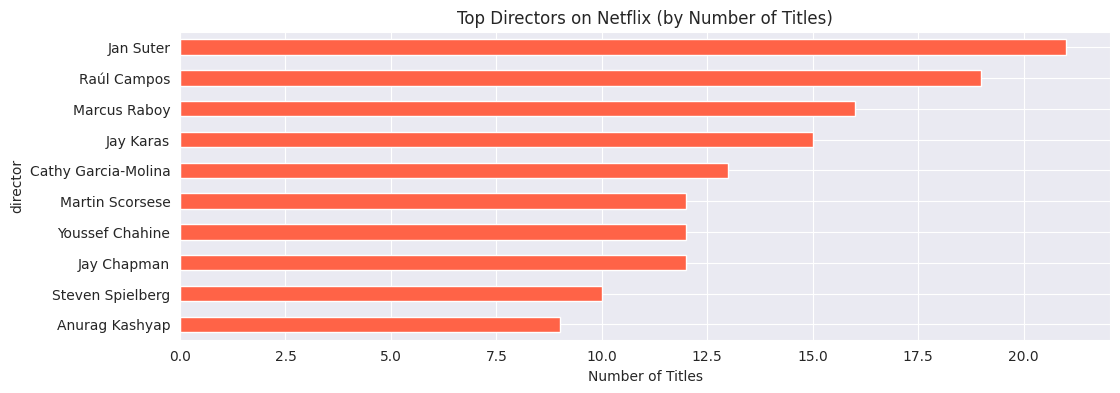

In [99]:
plt.figure(figsize=(12,4))
top_directors.plot(kind='barh', color='tomato')
plt.gca().invert_yaxis()
plt.title("Top Directors on Netflix (by Number of Titles)")
plt.xlabel("Number of Titles")
plt.show()

Based on the bar chart titled "Top Directors on Netflix (by Number of Titles)," here are a few insights:

* **Jan Suter** has the most titles on Netflix, with over 20.
* **Anurag Kashyap** has the fewest titles among the top 10 directors, with around 9.
* The number of titles for the top 10 directors ranges from approximately 9 to 21.
* The top five directors are Jan Suter, Raúl Campos, Marcus Raboy, Jay Karas, and Cathy Garcia-Molina.